<a href="https://colab.research.google.com/github/hibajamal/Value-Iteration-Simulation-Unity2D/blob/master/CV_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade tensorflow

Basic imports:

In [0]:
import tensorflow 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D, Activation, Reshape, Dropout, LeakyReLU
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.datasets import cifar10
import math
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2

Using TensorFlow backend.


# **Load and display the CIFAR-10 dataset:**

170500096/170498071 [==============================] - 4s 0us/step


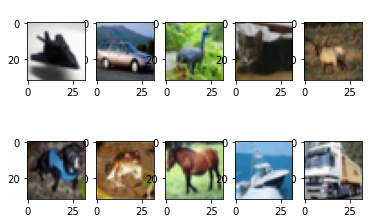

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# 9 classes
i, classes = 0, [i for i in range(10)]
label_txt = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', "ship", 'truck']

while len(classes) > 0:
  if y_train[i][0] in classes:
    # view images
    x = classes.pop(classes.index(y_train[i][0]))
    plt.subplot(2, 5, x+1)
    plt.title(label_txt[x], color='white')
    plt.imshow(x_train[i])
  i+=1

This dataset has 10 different classes, or 10 different elements which are mentioned by name in the label_txt list. Some preprocessing steps introduced to these images are normalizing it to a certain scale, applying gaussian blurs of different sizes on it to remove noise from the data, besides this we can use different kernel filters to highlight distinct features as well (depending on our goal).

# **Filtering function filt():**

In [0]:
def filt(inp, k, padding, normalization):
  output = None # filtered image
  x_dim, y_dim, z_dim = inp.shape[0], inp.shape[1], 1
  if len(inp.shape) == 2:
    inp = inp.reshape((inp.shape[0], inp.shape[0], 1))
  else:
    z_dim = inp.shape[2]
  if padding:
    x_pad, y_pad = math.ceil((k.shape[0]-1)/2), math.ceil((k.shape[1]-1)/2)
    res = []
    for i in inp:
      res.append(np.pad(i, [(x_pad, x_pad), (0, 0)], mode='constant'))
    pad = np.zeros(np.array(res).shape[1:])
    res = np.insert(res, 0, pad, axis=0)
    inp = np.append(res, np.array([pad]), axis=0)
  else:
    x_dim, y_dim = inp.shape[0] - k.shape[0] + 1, inp.shape[1] - k.shape[1] + 1
  if z_dim > 1: # slide filter on single channel input:
    output = np.array([[[0 for i in range(z_dim)] for j in range(y_dim)] for k in range(x_dim)]) # filtered image
    output = slideFil2D(k, inp, output)
  else: # slide filter on multiple filter input:
    output = np.array([[0 for i in range(y_dim)] for j in range(x_dim)])  # filtered image
    output = slideFil1D(k, inp, output)
  if normalization:
    output = output/255.0
  return output

def slideFil1D(filter, inp, output):
  for i in range(output.shape[0]):
    for j in range(ouput.shape[1]):
      output[i][j] = np.sum(inp[i:i+filer.shape[0], j:j+filter.shape[1]]*filter)
  return output

def slideFil2D(filter, inp, output):
  for i in range(output.shape[0]):
    for j in range(output.shape[1]):
      for k in range(output.shape[2]):
        output[i][j][k] = np.sum(inp[i:i+filter.shape[0], j:j+filter.shape[1], k]*filter)
  return output


Applying the filt() function:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


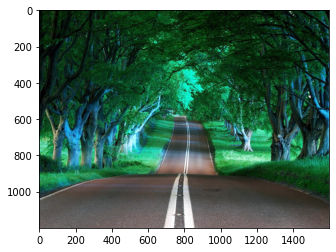

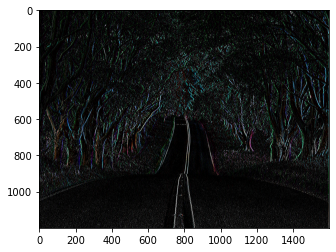

In [0]:
padding = True
normalization = True
# vertical edge detection filter
k = np.array([[1,0,-1],
              [1,0,-1],
              [1,0,-1]])

img = cv2.imread("211836.jpg")
plt.imshow(img)
plt.figure()
out = filt(img, k, padding, normalization)
plt.imshow(out)

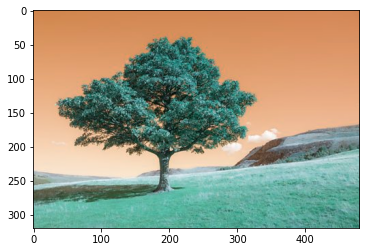

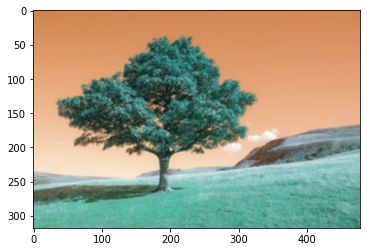

In [0]:
padding = False
normalization = True
# blurring filter
k = np.array([[1,2,1],
              [2,4,2],
              [1,2,1]])

img = cv2.imread("123456.jpg")
plt.imshow(img)
plt.figure()
out = filt(img, (1/16)*k, padding, normalization)
plt.imshow(out)

# **Extract HOG features from the CIFAR-10 dataset, and train a Linear SVM using those features:**

In [0]:
from skimage.feature import hog

fdx_train = []
fdx_test = []

for i in range(len(x_train)):
  fdx_train.append(hog(x_train[i], orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), multichannel=True))
  
for i in range(len(x_test)):
  fdx_test.append(hog(x_test[i], orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), multichannel=True))


In [0]:
fdx_train = np.array(fdx_train)
fdx_test = np.array(fdx_test)

In [0]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_model = svm.LinearSVC()
svm_model.fit(fdx_train, y_train)

In [0]:
acc = svm_model.predict(fdx_test)

In [0]:
print("Accuracy: "+str(accuracy_score(y_test, acc)))

Accuracy: 0.536


# **A feed forward neural network consisting of only fully connected layers:**
The dataset has only been loaded once in the beginning, and preprocessed and used accordingly for each neural network architecture.

Fully connected or dense layers here were at a disadvantage already since they cannot retain spatial information of images as convnets do. The images are preprocessed in a way to retain only important information by removing noise by a Gaussian 5x5 filter, and then normalized.

In [0]:
d_xtrain = []
d_xtest = []

for i in x_train:
  d_xtrain.append(cv2.GaussianBlur(i,(5,5),0))

for i in x_test:
  d_xtest.append(cv2.GaussianBlur(i,(5,5),0))

d_xtrain = np.array(d_xtrain)/255.0
d_xtest = np.array(d_xtest)/255.0

The model architecture is as follows. Various architectures were tried to manage accuracy but this one, coupled with its high batch size and kernel regularizer worked best to achieve the required accuracy.

In [0]:
model = Sequential()
model.add(Flatten())

model.add(Dense(720))
model.add(LeakyReLU(alpha=0.3))

model.add(Dense(512))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.2))

model.add(Dense(216))
model.add(LeakyReLU(alpha=0.3))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist1 = model.fit(d_xtrain, y_train, batch_size=1024, epochs=60, validation_data=(d_xtest, y_test), kernel_regularizer=regularizers.l2(0.001))

Epoch 1/60
49/49 [==============================] - 1s 13ms/step - loss: 2.4126 - accuracy: 0.1867 - val_loss: 1.9781 - val_accuracy: 0.2739
Epoch 2/60
49/49 [==============================] - 1s 10ms/step - loss: 1.9317 - accuracy: 0.2994 - val_loss: 1.8473 - val_accuracy: 0.3365
Epoch 3/60
49/49 [==============================] - 1s 11ms/step - loss: 1.8452 - accuracy: 0.3354 - val_loss: 1.7483 - val_accuracy: 0.3797
Epoch 4/60
49/49 [==============================] - 1s 11ms/step - loss: 1.7745 - accuracy: 0.3657 - val_loss: 1.7052 - val_accuracy: 0.3921
Epoch 5/60
49/49 [==============================] - 1s 10ms/step - loss: 1.7088 - accuracy: 0.3909 - val_loss: 1.6430 - val_accuracy: 0.4240
Epoch 6/60
49/49 [==============================] - 1s 10ms/step - loss: 1.6763 - accuracy: 0.4037 - val_loss: 1.6072 - val_accuracy: 0.4300
Epoch 7/60
49/49 [==============================] - 1s 11ms/step - loss: 1.6453 - accuracy: 0.4156 - val_loss: 1.6157 - val_accuracy: 0.4391
Epoch 8/60
49

Train and test loss and accuracy plots:

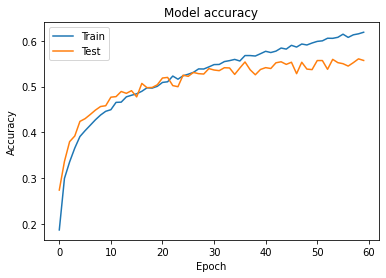

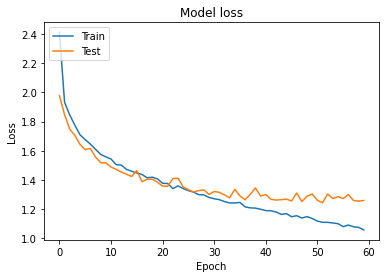

In [0]:
# Plot training & validation accuracy values
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# A convolutional neural network consisting of at least two convolutional layers: 

Data is normalized and then fed to the model for training.

In [0]:
cx_train = x_train/255.0
cx_test = x_test/255.0

In [0]:
conv_model = Sequential()
conv_model.add(Conv2D(32, (3,3), padding='same', activation="relu", name="conv1-1"))
conv_model.add(Conv2D(32, (3,3), padding='same', activation="relu", name="conv1-2"))
conv_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='max_pool_conv1'))

conv_model.add(Conv2D(64, (3,3), padding='same', activation="relu", name="conv2"))
conv_model.add(Dropout(0.2))
conv_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='max_pool_conv2'))

conv_model.add(Conv2D(64, (3,3), padding='same', activation="relu", name="conv3"))
conv_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='max_pool_conv3'))
conv_model.add(Dropout(0.2))

conv_model.add(Conv2D(32, (3,3), padding='same', activation="relu", name="conv4-1"))
conv_model.add(Conv2D(32, (3,3), padding='same', activation="relu", name="conv4-2"))
conv_model.add(Dropout(0.2))
conv_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='max_pool_conv4'))

conv_model.add(Flatten())
conv_model.add(Dense(32, activation="relu"))
conv_model.add(Dense(16, activation="relu"))
conv_model.add(Dropout(0.2))
conv_model.add(Dense(10, activation="softmax"))

In [0]:
conv_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy',  
                metrics=['accuracy'])
hist2 = conv_model.fit(cx_train, y_train, batch_size=230, epochs=90, validation_data=(cx_test, y_test))

Epoch 1/90
218/218 [==============================] - 5s 22ms/step - loss: 2.0135 - accuracy: 0.2325 - val_loss: 1.7457 - val_accuracy: 0.3807
Epoch 2/90
218/218 [==============================] - 5s 22ms/step - loss: 1.6595 - accuracy: 0.3760 - val_loss: 1.5238 - val_accuracy: 0.4619
Epoch 3/90
218/218 [==============================] - 5s 22ms/step - loss: 1.4471 - accuracy: 0.4639 - val_loss: 1.2962 - val_accuracy: 0.5616
Epoch 4/90
218/218 [==============================] - 5s 22ms/step - loss: 1.3069 - accuracy: 0.5241 - val_loss: 1.1617 - val_accuracy: 0.6112
Epoch 5/90
218/218 [==============================] - 5s 22ms/step - loss: 1.2057 - accuracy: 0.5639 - val_loss: 1.0694 - val_accuracy: 0.6301
Epoch 6/90
218/218 [==============================] - 5s 22ms/step - loss: 1.1292 - accuracy: 0.5978 - val_loss: 1.0438 - val_accuracy: 0.6637
Epoch 7/90
218/218 [==============================] - 5s 22ms/step - loss: 1.0611 - accuracy: 0.6241 - val_loss: 0.9719 - val_accuracy: 0.6787

Train and test loss and accuracy plots:

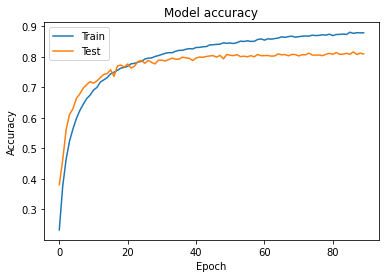

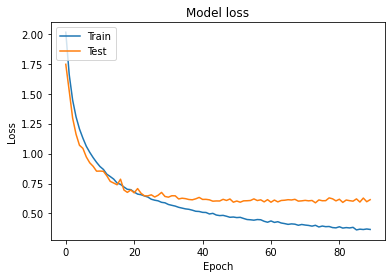

In [0]:
# Plot training & validation accuracy values
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Use the pre-trained VGG-16 network (trained on ImageNet) as a feature extractor, and connect it to a feed forward network consisting of fully connected layers:
The conv layers from VGG are extracted and connected to a customized dense-layer network.
Many different architectures were tried and they failed to achieve the required accuracy. So I resorted to stop playing with the architectures and hyperparameters of the dense network, and focus on preprocessing. The original VGG which is imported was trained on IMAGENET dataset, for who's classes, CIFAR10 is only a subset. Not only that but the IMAGENET images were greater in size. For CONVNETs extract information from images, and the CIFAR10 has small sized images (32x32), I thought perhaps upscaling them would allow the already state of the art VGG to perform better by exploring its input feature space more. And that worked to improve the accuracy on a small batch of training data. When the full dataset was used to train the network, the accuracy improved even further.

In [0]:
tl_xtrain = []
tl_xtest = []

for i in x_train:
  tl_xtrain.append(cv2.resize(i, (64,64), interpolation = cv2.INTER_AREA))

for i in x_test:
  tl_xtest.append(cv2.resize(i, (64,64), interpolation = cv2.INTER_AREA))



Then the images are normalized before the model is created.

In [0]:
tl_xtrain = np.array(tl_xtrain)/255.0
tl_xtest = np.array(tl_xtest)/255.0


In [0]:
vgg16 = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=tl_xtrain[0].shape)

for i in range(len(vgg16.layers)):
  vgg16.layers[i].trainable = False

flat = Flatten()(vgg16.layers[-1].output)

dense2 = Dense(512)(flat)
leakyr2 = LeakyReLU(alpha=0.001)(dense2)

dense3 = Dense(256)(leakyr2)
leakyr3 = LeakyReLU(alpha=0.001)(dense3)
drop2 = Dropout(0.2)(leakyr3)

dense4 = Dense(32)(drop2)
leakyr4 = LeakyReLU(alpha=0.001)(dense4)
drop3 = Dropout(0.2)(leakyr4)

dense5 = Dense(16)(drop3)
leakyr4 = LeakyReLU(alpha=0.001)(dense5)
out = Dense(10, activation="softmax")(leakyr4)

vgg16_ext = Model(inputs=vgg16.inputs, outputs=out)

#vgg16_ext.summary()

In [0]:
vgg16_ext.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist3 = vgg16_ext.fit(tl_xtrain, y_train, batch_size=256, epochs=8, validation_data=(tl_xtest, y_test))

Epoch 1/8
196/196 [==============================] - 13s 68ms/step - loss: 1.4185 - accuracy: 0.5057 - val_loss: 1.0283 - val_accuracy: 0.6486
Epoch 2/8
196/196 [==============================] - 13s 64ms/step - loss: 1.0441 - accuracy: 0.6458 - val_loss: 0.9270 - val_accuracy: 0.6899
Epoch 3/8
196/196 [==============================] - 13s 64ms/step - loss: 0.9129 - accuracy: 0.6944 - val_loss: 0.9153 - val_accuracy: 0.6875
Epoch 4/8
196/196 [==============================] - 13s 64ms/step - loss: 0.8309 - accuracy: 0.7227 - val_loss: 0.8819 - val_accuracy: 0.7062
Epoch 5/8
196/196 [==============================] - 13s 64ms/step - loss: 0.7700 - accuracy: 0.7429 - val_loss: 0.8682 - val_accuracy: 0.7122
Epoch 6/8
196/196 [==============================] - 13s 64ms/step - loss: 0.7139 - accuracy: 0.7613 - val_loss: 0.8749 - val_accuracy: 0.7116
Epoch 7/8
196/196 [==============================] - 13s 64ms/step - loss: 0.6578 - accuracy: 0.7798 - val_loss: 0.8638 - val_accuracy: 0.7133

Train and test loss and accuracy plots:

Looking at the results, the model's complexity could perhaps be managed better given the gap between training and validation losses. Nonetheless, my results are as follows:

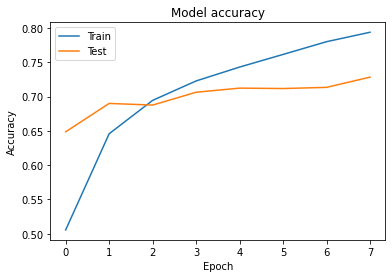

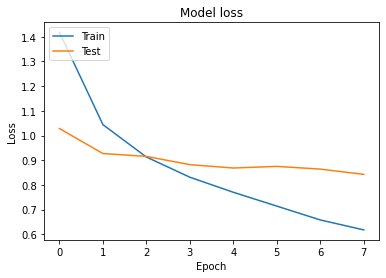

In [0]:
# Plot training & validation accuracy values
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()